<a href="https://colab.research.google.com/github/cbaldassari/gmm_init/blob/main/GMM_kmeans_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!pip install missingpy
import missingpy
from missingpy import MissForest
import statsmodels.api as sm
import pandas as pd
import numpy as np
from sklearn import mixture
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from scipy.stats import skew 
from scipy.stats import kurtosis
from tqdm import tqdm
import matplotlib.pyplot as plt

#preprocessing

In [ ]:
tag_data = pd.read_csv('/content/drive/MyDrive/Mari/plotpaper2/GMMdata.csv')

,Date,gas,oil,spx,pjm
0,2015-01-02,-0.033241,-0.011706,-0.000820,0.134948
1,2015-01-03,0.024393,-0.016112,-0.007269,0.023259
2,2015-01-04,0.022301,-0.034150,-0.008367,0.218619
3,2015-01-05,0.023783,-0.005484,-0.003760,-0.124662
4,2015-01-06,-0.076450,-0.043503,-0.009248,0.573400


#GRID SEARCH

In [ ]:
hubnames=["pjm","oil","gas","spx"]

for hub in hubnames:
  scaler = MinMaxScaler()
  X = scaler.fit_transform(tag_data[hub].values.reshape(-1, 1))
  
  trial=1000
  size = len(X)
  n_components=np.arange(1,31) #1:100 components

  idxs=np.arange(len(n_components))
  grid=pd.DataFrame(columns=["idxs","hub","avg2","std2","avg3","std3","avg4","std4","aic","bic","comp","weights","means","covariances"])
  grid.set_index("idxs")
  
  for components in tqdm(n_components):
      bic=[]
      aic=[]
      
      res=pd.DataFrame(columns=["idx","first","second","third","fourth"])
      res["idx"]=idxs
      res.set_index("idx")

      gmm = mixture.GaussianMixture(n_components=components,n_init=1000, covariance_type='full', init_params="kmeans").fit(X)
      bic=gmm.bic(X)
      aic=gmm.aic(X) 

      for cnt in range(trial): 
          data_new = gmm.sample(size)
          sample=data_new[0].reshape(-1, 1) 
          
          descaled_sample=scaler.inverse_transform(sample)
          samplezero=descaled_sample

          item={
                "2":samplezero.std(),
                "3":skew(samplezero)[0],
                "4":kurtosis(samplezero)[0]+3
                }
          
          res.at[cnt,"second"]=item["2"]
          res.at[cnt,"third"]=item["3"]
          res.at[cnt,"fourth"]=item["4"]
            
      grid.at[components,'hub']=hub
      grid.at[components,'avg2']=res["second"].mean()
      grid.at[components,'std2']=res["second"].std()

      grid.at[components,'avg3']=res["third"].mean()
      grid.at[components,'std3']=res["third"].std()

      grid.at[components,'avg4']=res["fourth"].mean()
      grid.at[components,'std4']=res["fourth"].std() 

      grid.at[components,'bic']=np.asarray(bic)
      grid.at[components,'aic']=np.asarray(aic)
      grid.at[components,'weights']=gmm.weights_
      grid.at[components,'means']=gmm.means_
      grid.at[components,'covariances']=gmm.covariances_
      grid.at[components,'comp']=gmm.n_components

      if (components!=gmm.n_components):
        print("ERROR")

  grid.to_csv("/content/drive/MyDrive/Mari/20210930_kmeans_GMM_"+hub+".csv")

100%|██████████| 30/30 [25:52<00:00, 51.73s/it]


#div


-5760.838969294658
-5821.441657220841


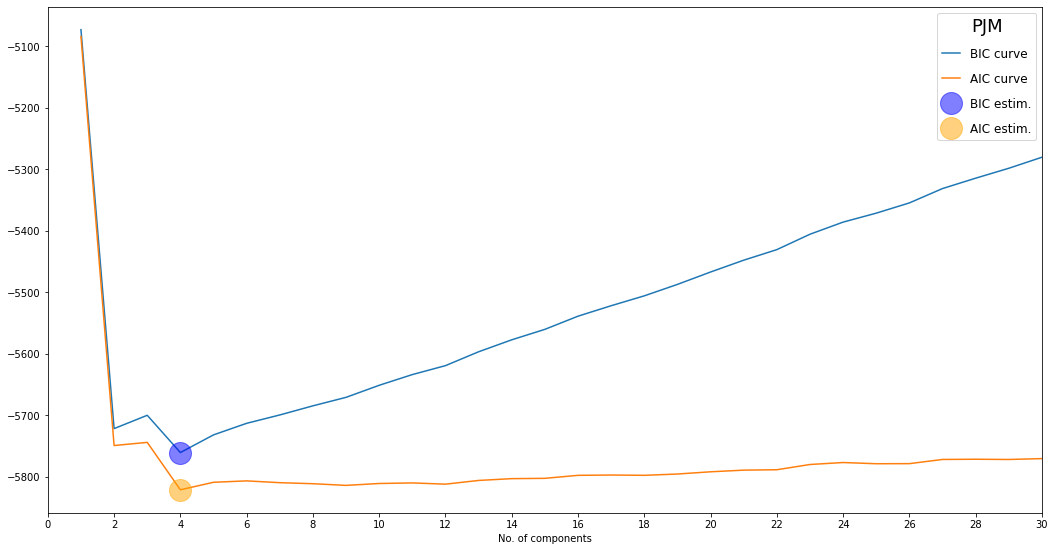

In [ ]:
pjm=pd.read_csv("/content/drive/MyDrive/Mari/20210930_kmeans_GMM_"+"pjm"""+".csv")

pjm.reset_index(drop=True, inplace=True)
pjm.set_index("Unnamed: 0", inplace=True)
ax = pjm["bic"].plot(figsize=(15,8),label="BIC curve")
ax1 = pjm["aic"].plot(figsize=(15,8),label="AIC curve")
plt.rcParams.update({'font.size': 18,'legend.fontsize': 12,'legend.handlelength': 1.5}) # must set in top
#

ax.xaxis.set_label_text("No. of components")
ax.legend(["bic","aic"],loc='upper right')

plt.xticks(np.arange(1,100),rotation=0)
plt.tight_layout()

ax.set_xlim([1,15])
ax.set_xticks(np.arange(0, 30+1, 2))

plt.plot(pjm.index[pjm['bic'] == pjm["bic"].min()].tolist()[0],pjm["bic"].min(), "s", c= "blue",label="BIC estim.",marker='o', alpha=.5,markersize=22)
plt.plot(pjm.index[pjm['aic'] == pjm["aic"].min()].tolist()[0],pjm["aic"].min(), "s",c= "orange",label="AIC estim.",marker='o', alpha=.5,markersize=22)

#plt.plot(pjm.index[pjm['comp'] == 7].tolist()[0],pjm["bic"][pjm['comp'] == 7].tolist()[0], "s", c= "red",label="SMM estim.", marker='X', alpha=.5,markersize=15)
#plt.plot(pjm.index[pjm['comp'] == 7].tolist()[0],pjm["aic"][pjm['comp'] == 7].tolist()[0], "s", c= "red",label="", marker='X', alpha=.5,markersize=15)
plt.legend(frameon=True, labelspacing=1, title='PJM',loc='upper right')


plt.savefig('/content/drive/MyDrive/Mari/plotpaper2/bicaicPJMkm.pdf')  # saves the current figure
print(pjm["bic"].min())
print(pjm["aic"].min())

plt.show()

In [ ]:
pjm

In [ ]:
pjm.index[pjm['aic'] == pjm["aic"].min()].tolist()[0]

4

-7069.411183880669
-7137.032731332274


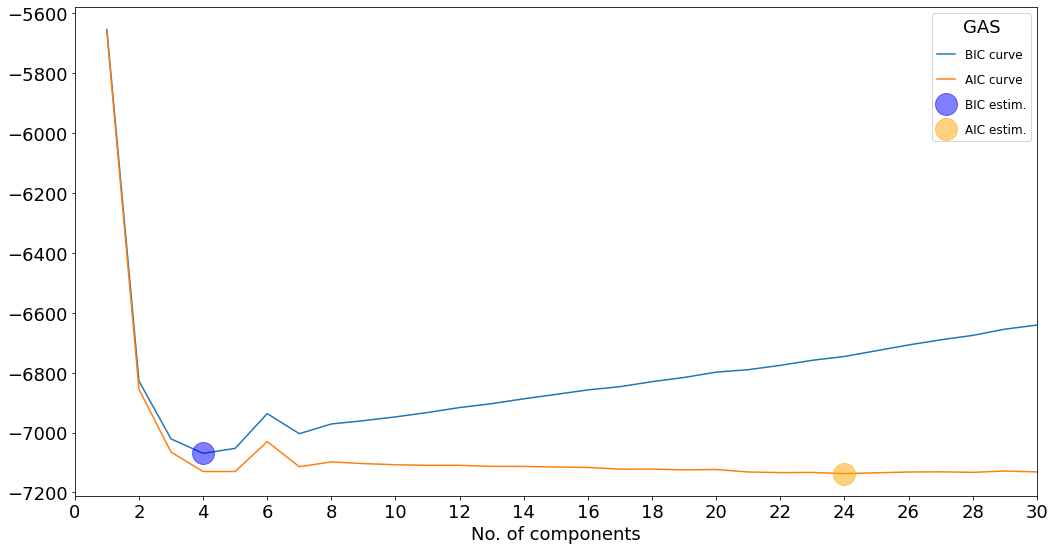

In [ ]:
gas=pd.read_csv("/content/drive/MyDrive/Mari/20210930_kmeans_GMM_"+"gas"""+".csv")

gas.reset_index(drop=True, inplace=True)
gas.set_index("Unnamed: 0", inplace=True)
ax = gas["bic"].plot(figsize=(15,8),label="BIC curve")
ax1 = gas["aic"].plot(figsize=(15,8),label="AIC curve")
plt.rcParams.update({'font.size': 18,'legend.fontsize': 12,'legend.handlelength': 1.5}) # must set in top

ax.xaxis.set_label_text("No. of components")
ax.legend(["bic","aic"])

plt.xticks(np.arange(1,100),rotation=0)
plt.tight_layout()
ax.set_xlim([1,30])
ax.set_xticks(np.arange(0, 30+1, 2))

#ax.set_ylim([-5885,-5050])
plt.plot(gas.index[gas['bic'] == gas["bic"].min()].tolist()[0],gas["bic"].min(), "s", c= "blue",label="BIC estim.",marker='o', alpha=.5,markersize=22)
plt.plot(gas.index[gas['aic'] == gas["aic"].min()].tolist()[0],gas["aic"].min(), "s", c= "orange",label="AIC estim.",marker='o', alpha=.5,markersize=22)

#plt.plot(gas.index[spx['comp'] == 7].tolist()[0],gas["bic"][gas['comp'] == 7].tolist()[0], "s", c= "red",label="SMM estim.", marker='X', alpha=.5,markersize=15)
#plt.plot(gas.index[spx['comp'] == 7].tolist()[0],gas["aic"][gas['comp'] == 7].tolist()[0], "s", c= "red",label="", marker='X', alpha=.5,markersize=15)
plt.legend(frameon=True, labelspacing=1, title='GAS',loc='upper right')

plt.savefig('/content/drive/MyDrive/Mari/plotpaper2/bicaicGASkm.pdf')  # saves the current figure
print(gas["bic"].min())
print(gas["aic"].min())
plt.show()

In [ ]:
gas

-3898.499434604375
-3942.009768943232


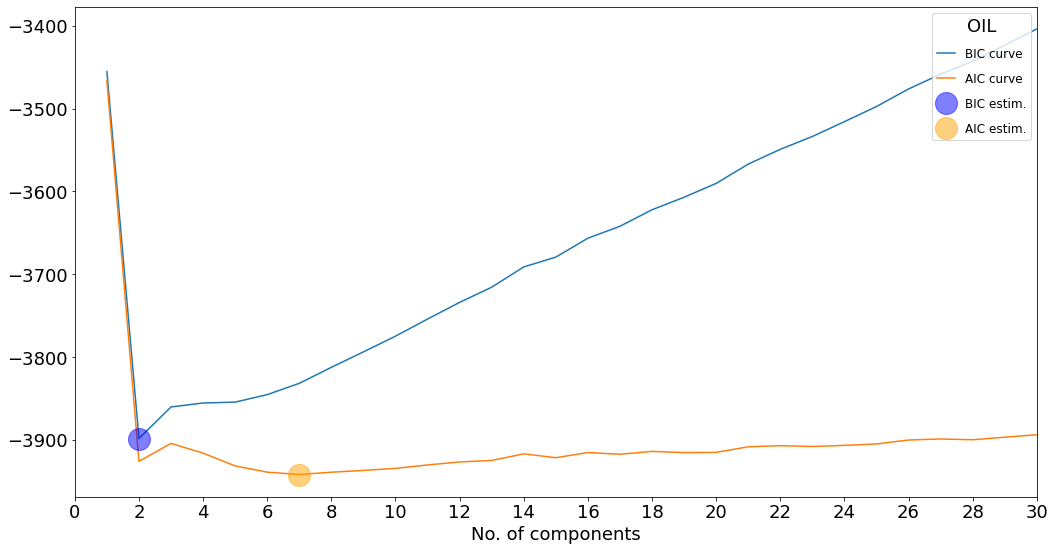

In [ ]:
oil=pd.read_csv("/content/drive/MyDrive/Mari/20210930_kmeans_GMM_"+"oil"""+".csv")

oil.reset_index(drop=True, inplace=True)
oil.set_index("Unnamed: 0", inplace=True)
ax = oil["bic"].plot(figsize=(15,8),label="BIC curve")
ax1 = oil["aic"].plot(figsize=(15,8),label="AIC curve")
plt.rcParams.update({'font.size': 18,'legend.fontsize': 12,'legend.handlelength': 1.5}) # must set in top

ax.xaxis.set_label_text("No. of components")
ax.legend(["bic","aic"])

plt.xticks(np.arange(1,100),rotation=0)
plt.tight_layout()
ax.set_xlim([1,30])
ax.set_xticks(np.arange(0, 30+1, 2))

#ax.set_ylim([-5885,-5050])
plt.plot(oil.index[oil['bic'] == oil["bic"].min()].tolist()[0],oil["bic"].min(), "s", c= "blue",label="BIC estim.",marker='o', alpha=.5,markersize=22)
plt.plot(oil.index[oil['aic'] == oil["aic"].min()].tolist()[0],oil["aic"].min(), "s", c= "orange",label="AIC estim.",marker='o', alpha=.5,markersize=22)

#plt.plot(oil.index[spx['comp'] == 7].tolist()[0],oil["bic"][oil['comp'] == 7].tolist()[0], "s", c= "red",label="SMM estim.", marker='X', alpha=.5,markersize=15)
#plt.plot(oil.index[spx['comp'] == 7].tolist()[0],oil["aic"][oil['comp'] == 7].tolist()[0], "s", c= "red",label="", marker='X', alpha=.5,markersize=15)
plt.legend(frameon=True, labelspacing=1, title='OIL',loc='upper right')

plt.savefig('/content/drive/MyDrive/Mari/plotpaper2/bicaicOILkm.pdf')  # saves the current figure
print(oil["bic"].min())
print(oil["aic"].min())
plt.show()

In [ ]:
oil

-4400.088335692373
-4460.691023618556


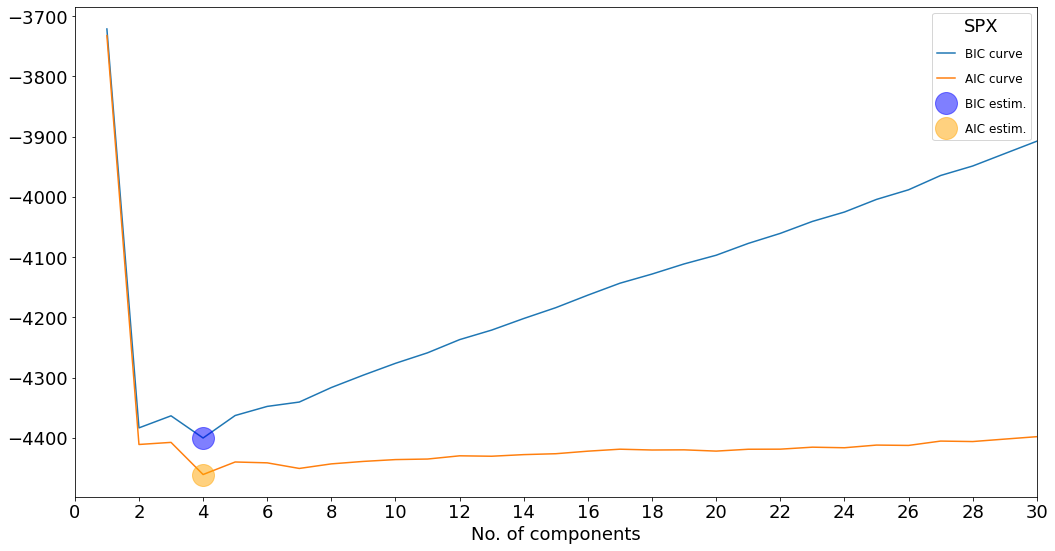

In [ ]:
spx=pd.read_csv("/content/drive/MyDrive/Mari/20210930_kmeans_GMM_"+"spx"""+".csv")

spx.reset_index(drop=True, inplace=True)
spx.set_index("Unnamed: 0", inplace=True)
ax = spx["bic"].plot(figsize=(15,8),label="BIC curve")
ax1 = spx["aic"].plot(figsize=(15,8),label="AIC curve")
plt.rcParams.update({'font.size': 18,'legend.fontsize': 12,'legend.handlelength': 1.5}) # must set in top

ax.xaxis.set_label_text("No. of components")
#ax.legend(["BIC","AIC"])

plt.xticks(np.arange(1,100),rotation=0)
plt.tight_layout()
ax.set_xlim([1,30])
#ax.set_ylim([-5885,-5050])
ax.set_xticks(np.arange(0, 30+1, 2))

plt.plot(spx.index[spx['bic'] == spx["bic"].min()].tolist()[0],spx["bic"].min(), "s", c= "blue",label="BIC estim.",marker='o', alpha=.5,markersize=22)
plt.plot(spx.index[spx['aic'] == spx["aic"].min()].tolist()[0],spx["aic"].min(), "s", c= "orange",label="AIC estim.",marker='o', alpha=.5,markersize=22)

#plt.plot(spx.index[spx['comp'] == 7].tolist()[0],spx["bic"][spx['comp'] == 7].tolist()[0], "s", c= "red",label="SMM estim.", marker='X', alpha=.5,markersize=15)
#plt.plot(spx.index[spx['comp'] == 7].tolist()[0],spx["aic"][spx['comp'] == 7].tolist()[0], "s", c= "red",label="", marker='X', alpha=.5,markersize=15)

plt.legend(frameon=True, labelspacing=1, title='SPX',loc='upper right')

plt.savefig('/content/drive/MyDrive/Mari/plotpaper2/bicaicSPXkm.pdf')  # saves the current figure
print(spx["bic"].min())
print(spx["aic"].min())
plt.show()


In [ ]:
spx

#Valutazione dei risultati della griglia

In [ ]:
df=pd.DataFrame()

In [ ]:
hubnames=["oil"]#"std2","std3","std4"
df=pd.DataFrame(columns=["hub","frac","comp","bic","aic","weights"])

for hub in hubnames:
  grid2=pd.read_csv("/content/drive/MyDrive/Mari/20210930_kmeans_GMM_"+hub+".csv")

  itemorig={"1":tag_data[hub].mean(),
        "2":tag_data[hub].std(),
        "3":skew(tag_data[hub]),
        "4":kurtosis(tag_data[hub])+3
  }
  fraction=2

  for index, row in grid2.iterrows():
    if (  (abs(row["avg2"]-itemorig["2"])< (row["std2"])/fraction) and  
          (abs(row["avg3"]-itemorig["3"])< (row["std3"])/fraction) and  
          (abs(row["avg4"]-itemorig["4"])< (row["std4"])/fraction)
        ):  
        dictionary={"hub":hub,"frac":fraction,
                    "comp":index+1,
                    "bic":row["bic"],
                    "aic":row["aic"],
                    "weights":row["weights"],
                    "means":row["means"],
                    "covariances":row["covariances"]}
        df = df.append(dictionary, ignore_index=True)
df[df["comp"]==df["comp"].min()]


,hub,frac,comp,bic,aic,weights,covariances,means
0,oil,2,6,-3845.462237,-3939.120937,[0.48258929 0.06554616 0.05960549 0.19427311 0...,[[[0.0006493 ]]\n\n [[0.00331353]]\n\n [[0.007...,[[0.44640917]\n [0.61542473]\n [0.25897391]\n ...


In [ ]:
hub="gas"
c=25
grid2=pd.read_csv("/content/drive/MyDrive/Mari/20210902_kmeans_GMM_"+hub+".csv")

w=grid2["weights"][grid2["comp"]==c].to_list()[0]
w=w[1:-1]
w=w.split()
w.sort(reverse=False)

l_sf_f = [round(float(s),3) for s in w]
l_sf_f.sort(reverse=True)
cstr=''
for it in l_sf_f:
  cstr+=" "+str(it)
cstr

' 0.214 0.116 0.095 0.09 0.088 0.074 0.069 0.057 0.046 0.035 0.029 0.028 0.019 0.014 0.008 0.005 0.003 0.003 0.002 0.002 0.001 0.001 0.001 0.001 0.001'

In [ ]:
-4450.763293	-4340.576587

In [ ]:
hub="spx"
comp=7
data=pd.read_csv("/content/drive/MyDrive/Mari/20210902_kmeans_GMM_"+hub+".csv")
itemorig={"1":stochastic[hub].mean(),
      "2":stochastic[hub].std(),
      "3":skew(stochastic[hub]),
      "4":kurtosis(stochastic[hub])+3
}

print("&"+str(data.loc[comp,"avg2"]-itemorig["2"])+"& "+str(data.loc[comp,"avg3"]-itemorig["3"])+"& "+str(data.loc[comp,"avg4"]-itemorig["4"]))

&-3.428036282533166e-06& 0.0070676488878066435& -0.13429470563006518


In [ ]:
data.loc[3,"avg2"]

0.15871125985140536

In [ ]:
data

,Unnamed: 0,idxs,avg1,std1,avg2,std2,avg3,std3,avg4,std4,aic,bic,comp,weightscomp_1,weightscomp_5,weightscomp_10
0,1,NaN,0.000223,0.003739,0.158995,0.002587,-0.000169,0.056432,2.992846,0.114659,-5083.871187,-5072.852516,1,1,1,1
1,2,NaN,0.000118,0.003560,0.158918,0.005490,0.242287,0.261162,9.119083,0.877545,-5749.418323,-5721.871647,2,2,2,2
2,3,NaN,0.000107,0.003906,0.159091,0.004787,-0.017272,0.213525,7.895451,0.614536,-5744.302756,-5700.228074,3,3,3,3
3,4,NaN,0.000249,0.003704,0.158711,0.006398,-0.015799,0.427222,12.423003,2.032801,-5820.535838,-5759.933150,4,4,4,3
4,5,NaN,0.000137,0.003846,0.159368,0.006181,-0.128057,0.413607,12.440622,1.571344,-5809.156821,-5732.026128,5,5,3,3
5,6,NaN,0.000004,0.003710,0.158943,0.006543,-0.101187,0.422728,12.547203,1.541758,-5806.691523,-5713.032823,6,6,4,3
6,7,NaN,0.000157,0.003798,0.159016,0.006850,-0.209468,0.557099,14.517644,3.493292,-5809.862240,-5699.675535,7,6,4,3
7,8,NaN,0.000246,0.003830,0.158967,0.006849,-0.191259,0.537988,14.327099,3.200077,-5814.266718,-5687.552007,8,6,4,3
8,9,NaN,0.000024,0.003592,0.159091,0.006947,-0.228033,0.547634,14.511947,3.304052,-5814.628061,-5671.385344,9,7,5,3
9,10,NaN,0.000100,0.003728,0.159025,0.006808,-0.203399,0.562441,14.531191,3.265170,-5811.248048,-5651.477326,10,8,5,4
